<a href="https://colab.research.google.com/github/absallh/AI_project/blob/master/ensambleProjectWithNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
#delete all moedels
#!rm -rf saved_model/

#download saved models folder
#!zip -r saved_model.zip saved_model
# from google.colab import files
# files.download("saved_model.zip")

#unzip uploaded file
# !unzip saved_model.zip -d saved_model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import confusion_matrix
from keras.models import load_model
import os
import gc
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# load the dataset (that contain all the image and its label)
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

#names of the classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# We know that cifar10 images are 32 pixels in each dimension.
img_size = 32

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = len(class_names)

In [ ]:
# tha shape of the train dataset
print("the all train set: \t", train_images.shape)
print("the all train labels: \t", train_labels.shape)
combined_size = len(train_images)
print("the all train size: \t", combined_size)
train_size = int(0.7 * combined_size)#the size of the trainingset
print("single model train size: \t", train_size)
validation_size = combined_size - train_size
print("single model validation size: \t", validation_size)

the all train set: 	 (50000, 32, 32, 3)
the all train labels: 	 (50000, 1)
the all train size: 	 50000
single model train size: 	 35000
single model validation size: 	 15000


In [ ]:
#some variables that build our program
epochs = 15 #the number that every model train on its dataset
nets = 4 #the number of the models
train_size = int(0.7 * combined_size)#the size of the trainingset
Models = [0]*nets #models that bulided
history = []  #validation of the builded models
test_loss = [0]*nets  #loss fn of the trained models
test_acc = [0]*nets #the acurancy of the trained models
startTrainingTime = time.time() #the stating time of the program
loadedModels = [0]*nets #models that loaded from the saved files

In [ ]:
def dataAugmentation(x, y):
  datagen = ImageDataGenerator(
     rotation_range=40,
     width_shift_range=0.2,
     height_shift_range=0.2,
     shear_range=0.2,
     zoom_range=0.2,
     horizontal_flip=True,
     fill_mode='nearest')

  datagen.fit(x)
  return datagen.flow(x, y, batch_size=32)

In [ ]:
def random_training_set():
    # Create a randomized index into the full / combined training-set.
    idx = np.random.permutation(combined_size)

    # Split the random index into training- and validation-sets.
    idx_train = idx[0:train_size]
    idx_validation = idx[train_size:]

    # Select the images and labels for the new training-set.
    x_train = train_images[idx_train, :]
    y_train = train_labels[idx_train, :]
    # Select the images and labels for the new validation-set.
    x_validation = train_images[idx_validation, :]
    y_validation = train_labels[idx_validation, :]

    y_train = np_utils.to_categorical(y_train, num_classes)
    y_validation = np_utils.to_categorical(y_validation, num_classes)
    # Return the new training- and validation-sets.
    return dataAugmentation(x_train, y_train), x_validation, y_validation

In [ ]:
def build_model(modelNumber):
    print("model #", modelNumber)

    # Create a random training-set. (subset of the all training set)
    training_set, x_validation, y_validation = random_training_set()
    resize_layer = tf.keras.Sequential([
        layers.experimental.preprocessing.Resizing(img_size, img_size)
      ])
    # build the CNN models
    Models[modelNumber] = models.Sequential([
        resize_layer,
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ]) 
    # compile the model
    Models[modelNumber].compile(
              optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
              metrics=['accuracy'])
    
    # vaildate/train the model
    history.append(Models[modelNumber].fit(training_set,
              epochs=epochs, validation_data=(x_validation, y_validation)))
    # evaluate the model (know how perform our single model)
    print("model #", modelNumber, "Done")
    test_loss[modelNumber], test_acc[modelNumber] = Models[modelNumber].evaluate(x_validation, y_validation, verbose=2)

In [ ]:
def load_all_models ():
  #load models at loadedModels array
  for i in range(nets):
    dir = 'saved_model/model'+str(i)
    loadedModels[i] = load_model(dir)

In [ ]:
def save_all_models ():
  #save all models
  !mkdir -p saved_model
  for i in range(nets):
    Models[i].save("saved_model/model"+str(i))

In [ ]:
def predict_single_image(img):
  img = np.expand_dims(img, 0)
  prediction = [0]*nets
  for i in range(nets):
    prediction[i] = loadedModels[0].predict(img)
  
  prediction = np.array(prediction)
  prediction_array = prediction.ravel()
  # argmax across classes
  outcomes = np.argmax(prediction_array,  axis=0)
  return outcomes

In [ ]:
def ensamble_acc():
  pred_labels = []
  is_correct_labels = 0
  for i in range(len(test_images)):
    pred_labels.append(predict_single_image(test_images[i]))
    gc.collect()
    #append 0 if the prediction is wrong, append 1 otherwise
    #print(pred_labels[i] == test_labels[i])
    # if (i == 1000):
    #   break
    if (pred_labels[i] == test_labels[i]):
      is_correct_labels += 1
  
  return (is_correct_labels/len(test_images))

In [ ]:
#load or build the models
if not os.path.isdir('saved_model/'):
  for i in range(nets):
    build_model(i)
  save_all_models()
print("training time = ",time.time() - startTrainingTime)
load_all_models()

model # 0
Epoch 1/15
1094/1094 [==============================] - 147s 134ms/step - loss: 3.3780 - accuracy: 0.1986 - val_loss: 1.7771 - val_accuracy: 0.3989
Epoch 2/15
1094/1094 [==============================] - 146s 133ms/step - loss: 1.8665 - accuracy: 0.3593 - val_loss: 1.7055 - val_accuracy: 0.4465
Epoch 3/15
1094/1094 [==============================] - 145s 133ms/step - loss: 1.7668 - accuracy: 0.4118 - val_loss: 1.7526 - val_accuracy: 0.4380
Epoch 4/15
1094/1094 [==============================] - 146s 134ms/step - loss: 1.7237 - accuracy: 0.4322 - val_loss: 1.6108 - val_accuracy: 0.4969
Epoch 5/15
1094/1094 [==============================] - 147s 134ms/step - loss: 1.6705 - accuracy: 0.4621 - val_loss: 1.6637 - val_accuracy: 0.5020
Epoch 6/15
1094/1094 [==============================] - 145s 133ms/step - loss: 1.6458 - accuracy: 0.4794 - val_loss: 1.7148 - val_accuracy: 0.4729
Epoch 7/15
1094/1094 [==============================] - 146s 133ms/step - loss: 1.6251 - accuracy: 0.4

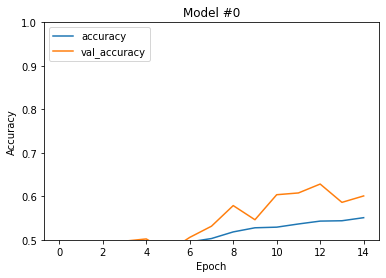

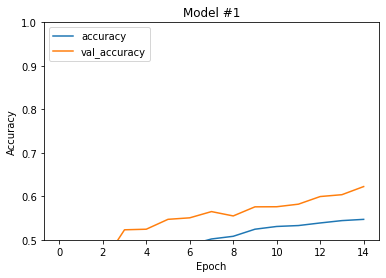

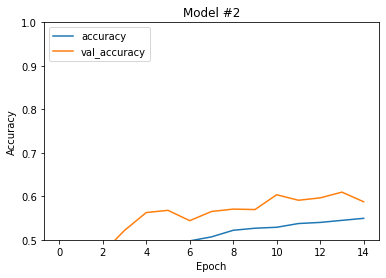

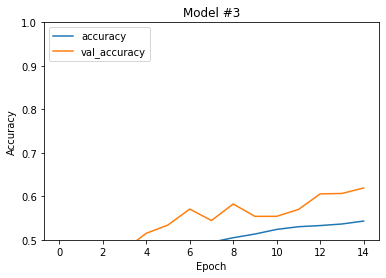

In [ ]:
def show_all_models_graphs ():
  for i in range(nets):
    plt.plot(history[i].history['accuracy'], label='accuracy')
    plt.plot(history[i].history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='upper left')
    plt.title('Model #{}'.format(i))
    plt.show()


show_all_models_graphs ()

ship


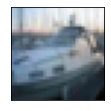

ship


In [ ]:
predictImag = 2
print(class_names[predict_single_image(test_images[predictImag])])
plt.figure(figsize=(10,10))
plt.subplot(5,5,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(test_images[predictImag], cmap=plt.cm.binary)
plt.show()
print(class_names[int(test_labels[predictImag])])